**"I / we certify that the code and data in this assignment were generated independently, using only the tools
and resources defined in the course and that I/we did not receive any external help, coaching, or contributions
during the production of this work."**

In [2]:
import numpy as np
import time
import matplotlib.pyplot as plt
import gym
from gym import spaces
from matplotlib.offsetbox import (AnnotationBbox, OffsetImage)
import cv2
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import deque, namedtuple

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
class Actor(nn.Module):

    def __init__(self,n_inputs, n_actions):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(n_inputs, 56),
            nn.Tanh(),
            nn.Linear(56, 28),
            nn.Tanh(),
            nn.Linear(28, n_actions),
            nn.Softmax(dim=0)
        )
    
    def forward(self, x):
        return self.model(x)
        
class Critic(nn.Module):
    def __init__(self, state_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(state_dim, 56),
            nn.ReLU(),
            nn.Linear(56,28),
            nn.ReLU(),
            nn.Linear(28, 1)
        )
    
    def forward(self, X):
        return self.model(X)

In [233]:
def train(env,lrate,g,epochs,count,grid=0):
    eps_rewards = []
    if(grid==0):
        states= env.observation_space.n
    else:
        states= env.observation_space.shape[0]
    n_actions = env.action_space.n
    actor = Actor(states, n_actions)
    critic = Critic(states)
    actor_opt = optim.Adam(actor.parameters(),lr=lrate)
    critic_opt = optim.Adam(critic.parameters(), lr=lrate)
    gamma = g
    
    for i in range(epochs):
        done = False
        score = 0
        state = env.reset()
        #print(state)
        s=0
        while not done:
            #probs = actor(torch.from_numpy(state).float())
            v = torch.distributions.Categorical(probs=actor(torch.from_numpy(state).float()))
            action = v.sample()
            s+=1
            next_state, reward, done, info = env.step(action.detach().data.numpy())
            a = reward + (1-done)*gamma*critic(torch.from_numpy(next_state).float()) - critic(torch.from_numpy(state).float())
            
            score += reward
            state = next_state

            critic_loss = (a**2).mean()
            actor_loss = -v.log_prob(action)*a.detach()
            
            critic_opt.zero_grad()
            actor_opt.zero_grad()
            critic_loss.backward()
            actor_loss.backward()
            critic_opt.step()
            actor_opt.step()
        
        #print(i,score,done)      
        eps_rewards.append(score)
        
        if(np.mean(eps_rewards[-10:])>=470 and count==0):
            torch.save(actor,"actor_model_cartpole.pt")
            break
        #print(np.mean(eps_rewards[-10:]),count)
        if(np.mean(eps_rewards[-10:])>=200 and count==2):
            #print(score)
            torch.save(actor,"actor_model_lunarlander.pt")
            break
        if(np.mean(eps_rewards[-5:])==8 and count==3):
            torch.save(actor,"actor_model_grid.pt")
        
    
    return eps_rewards
        

In [6]:

def evaluate_model(env,actor, eval_epochs):
    # Score List for logging
    score_data = []

    # Episodes iteration
    for x in range(eval_epochs):

        # Resetting the environment
        state = env.reset()
        done = False
        score = 0

        # While loop for the iterations
        while not done:

            with torch.no_grad():
                actor.eval()
                v = torch.distributions.Categorical(probs=actor(torch.from_numpy(state).float()))
                action = v.sample()
            new_state, reward, done, _ = env.step(action.numpy())

            state = new_state
            # Adding the reward to the score
            score += reward 
        score_data.append(score)
    return score_data

**PART 1**

**GRID Environment**

In [8]:
class GridEnvironment(gym.Env):
    
    def __init__(self):
        self.observation_space = spaces.Discrete(16)
        self.action_space = spaces.Discrete(4)
        self.timestep = 0
        self.max_timesteps = 100
        
        self.max_episodes=1000
        self.max_epsi=1
        self.min_epsi=0.01
        self.decayfactor=0.01
        self.alpha=0.14
        self.gamma=0.6
        
    def reset(self):
        self.timestep = 0

        #count
        self.carrotcount=2
        self.hurdlecount=1
        self.trapcount=1

        #positions
        self.rabbit_pos = [0, 0]
        self.goal = [3, 3]
        self.trap= [1,1]
        self.hurdle=[3,2]
        self.carrot1=[1,3]
        self.carrot2=[2,0]
        self.carrot1_collect=False
        self.carrot2_collect=False
        self.hurdlegotrabbit=False
        self.trapgotrabbit=False

        self.state = np.zeros((4,4))

        self.state[tuple(self.rabbit_pos)] = 1
        self.state[tuple(self.trap)] = 2
        self.state[tuple(self.hurdle)] = 2
        self.state[tuple(self.carrot1)] = 3
        self.state[tuple(self.carrot2)] = 3
        self.state[tuple(self.goal)] = 4
          
        obs= self.state.flatten()
        return obs

    
    def step(self, action):
     
      done = False
      self.hurdlegotrabbit=False
      self.trapgotrabbit=False
     

      """
        action=0 up
        action=1 down
        action=2 left
        action=3 right
      """  
  
      if action == 0:
        self.rabbit_pos[1] += 1
      if action == 1:
        self.rabbit_pos[1] -= 1
      if action == 2:
        self.rabbit_pos[0] -= 1
      if action == 3:
        self.rabbit_pos[0] += 1

      #Clipping the position so that the agent doesn't go out of the grid
      self.rabbit_pos = np.clip(self.rabbit_pos, 0, 3)
      self.state[tuple(self.rabbit_pos)] = 1
      obs= self.state.flatten()

      reward = 0
      if (self.rabbit_pos == self.goal).all():
        reward = 6
        done=True
      elif (self.rabbit_pos == self.trap).all() and self.trapgotrabbit==False and self.trapcount>0:
        reward = -2
        self.trapgotrabbit=True
        self.trapcount -=2
      elif (self.rabbit_pos == self.hurdle).all() and self.hurdlegotrabbit==False and self.hurdlecount>0:
        reward = -2
        self.hurdlegotrabbit=True
        self.hurdlecount -=1
      elif (self.rabbit_pos == self.carrot1).all() and self.carrot1_collect==False and self.carrotcount>0:
        self.carrot1_collect=True
        reward = 2
        self.carrotcount -=1
      elif (self.rabbit_pos == self.carrot2).all() and self.carrot2_collect==False and self.carrotcount>0:
        self.carrot2_collect=True
        reward = 2
        self.carrotcount -=1
         
      self.timestep += 1
      done = True if self.timestep >= self.max_timesteps or done==True else False
      if(done==True or self.timestep==100):
        print(self.timestep)
      info=False
      return obs,reward, done,info
        
    def render(self):
      fig,ax=plt.subplots(figsize=(10,10))
      ax.set_xlim(0,4)
      ax.set_ylim(0,4)

      def plot_image(plot_pos):
        
        plot_rabbit,plot_hurdle,plot_trap,plot_carrot1,plot_carrot2,plot_goal=False,False,False,False,False,False

        if (self.rabbit_pos == plot_pos).all():
          plot_rabbit=True
        if (self.hurdle == plot_pos).all() :
          plot_hurdle=True
        if (self.trap== plot_pos).all() :
          plot_trap=True
        if (self.carrot1 == plot_pos).all() and self.carrot1_collect==False:
          plot_carrot1=True
        if (self.carrot2 == plot_pos).all() and self.carrot2_collect==False:
          plot_carrot2=True
        if (self.goal == plot_pos).all():
          plot_goal=True

        #plot for rabbit
        if plot_rabbit and all(not item for item in [plot_hurdle,plot_goal,plot_carrot1,plot_carrot2,plot_trap]):
          rabbit=AnnotationBbox(OffsetImage(plt.imread('./images/rabbit.jpg'),zoom=0.28),np.add(plot_pos,[0.5,0.5]),frameon=False)
          ax.add_artist(rabbit)

        #plot for trap
        elif plot_trap and self.trapcount>0 and all(not item for item in [plot_rabbit,plot_hurdle,plot_goal,plot_carrot1,plot_carrot2]):
          trap=AnnotationBbox(OffsetImage(plt.imread('./images/trap.jpg'),zoom=0.2),np.add(plot_pos,[0.5,0.5]),frameon=False)
          ax.add_artist(trap)
        
        #plot for hurdle
        elif plot_hurdle and self.hurdlecount>0 and all(not item for item in [plot_rabbit,plot_trap,plot_goal,plot_carrot1,plot_carrot2]):
          hurdle=AnnotationBbox(OffsetImage(plt.imread('./images/hurdle.jpg'),zoom=0.37),np.add(plot_pos,[0.5,0.5]),frameon=False)
          ax.add_artist(hurdle)
        
        #plot for carrot1
        elif plot_carrot1  and all(not item for item in [plot_rabbit,plot_hurdle,plot_goal,plot_carrot2,plot_trap]):
          carrot=AnnotationBbox(OffsetImage(plt.imread('./images/carrot.png'),zoom=0.12),np.add(plot_pos,[0.5,0.5]),frameon=False)
          ax.add_artist(carrot)
        
        #plot for carrot2
        elif plot_carrot2 and all(not item for item in [plot_rabbit,plot_hurdle,plot_goal,plot_carrot1,plot_trap]):
          carrot=AnnotationBbox(OffsetImage(plt.imread('./images/carrot.png'),zoom=0.12),np.add(plot_pos,[0.5,0.5]),frameon=False)
          ax.add_artist(carrot)
        
        #plot for goal
        elif plot_goal and all(not item for item in [plot_rabbit,plot_hurdle,plot_carrot2,plot_trap,plot_carrot1]):
          goal=AnnotationBbox(OffsetImage(plt.imread('./images/goal.jpg'),zoom=0.25),np.add(plot_pos,[0.5,0.5]),frameon=False)
          ax.add_artist(goal)

        #plot for rabbit getting trapped
        elif all(item for item in[plot_rabbit,plot_trap]) and self.trapgotrabbit==True and all(not item for item in [plot_hurdle,plot_goal,plot_carrot1,plot_carrot2]):
          rabbit_trap=AnnotationBbox(OffsetImage(plt.imread('./images/rabbit_trap.png'),zoom=0.7),np.add(plot_pos,[0.5,0.5]),frameon=False)
          ax.add_artist(rabbit_trap)
        elif all(item for item in[plot_rabbit,plot_trap]) and self.trapgotrabbit==False and all(not item for item in [plot_hurdle,plot_goal,plot_carrot1,plot_carrot2]):
          rabbit=AnnotationBbox(OffsetImage(plt.imread('./images/rabbit.jpg'),zoom=0.28),np.add(plot_pos,[0.5,0.5]),frameon=False)
          ax.add_artist(rabbit)

        #plot for rabbit got to a hurdle
        elif all(item for item in[plot_rabbit,plot_hurdle]) and self.hurdlegotrabbit==True and all(not item for item in [plot_trap,plot_goal,plot_carrot1,plot_carrot2]):
          rabbit_hurdle=AnnotationBbox(OffsetImage(plt.imread('./images/rabbit_hurdle.jpeg'),zoom=0.1),np.add(plot_pos,[0.5,0.5]),frameon=False)
          ax.add_artist(rabbit_hurdle)
        elif all(item for item in[plot_rabbit,plot_hurdle]) and self.hurdlegotrabbit==False and all(not item for item in [plot_trap,plot_goal,plot_carrot1,plot_carrot2]):
          rabbit=AnnotationBbox(OffsetImage(plt.imread('./images/rabbit.jpg'),zoom=0.28),np.add(plot_pos,[0.5,0.5]),frameon=False)
          ax.add_artist(rabbit)

        #rabbit reaching the goal
        elif all(item for item in[plot_rabbit,plot_goal]) and all(not item for item in [plot_trap,plot_hurdle,plot_carrot1,plot_carrot2]):
          rabbit_goal=AnnotationBbox(OffsetImage(plt.imread('./images/rabbit_goal.png'),zoom=0.4),np.add(plot_pos,[0.5,0.5]),frameon=False)
          ax.add_artist(rabbit_goal)
    
      state_mapping={}
      for j in range(16):
        state_mapping[j]=np.asarray([j%4,int(np.floor(j/4))])

      for position in state_mapping:
        plot_image(state_mapping[position])
    
      plt.xticks([0,1,2,3,4])
      plt.yticks([0,1,2,3,4])
      plt.grid()
      plt.show()

In [148]:
env = GridEnvironment()
env.reset()
eps_rewards=train(env,0.0001,0.9,1000,3,0)

In [235]:
grid=torch.load("actor_model_grid.pt")
cp = evaluate_model(env,grid, 10)

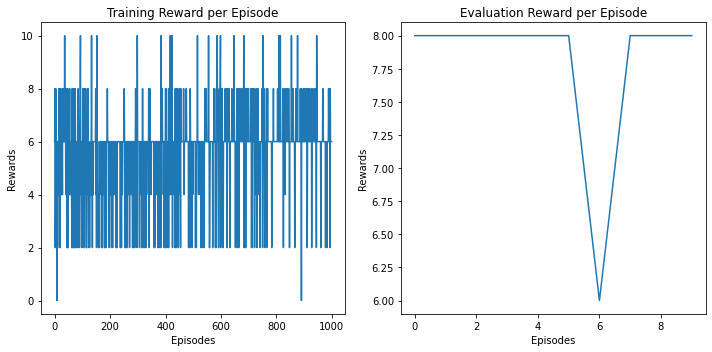

In [234]:
fig = plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
xn = range(len(eps_rewards))
plt.plot(xn,eps_rewards)
plt.title('Training Reward per Episode')
plt.ylabel('Rewards')
plt.xlabel('Episodes')


plt.subplot(1,2,2)
x1= range(len(cp))
plt.plot(x1,cp)
plt.title('Evaluation Reward per Episode')
plt.ylabel('Rewards')
plt.xlabel('Episodes')

fig.tight_layout()
plt.show()

**PART 2**

**CartPole**

In [171]:
env1 = gym.make("CartPole-v1")
eps_rewards1=train(env1,0.001,0.99,600,0,1)


In [237]:
actor=torch.load("actor_model_cartpole.pt")
cp1 = evaluate_model(env1,actor, 10)

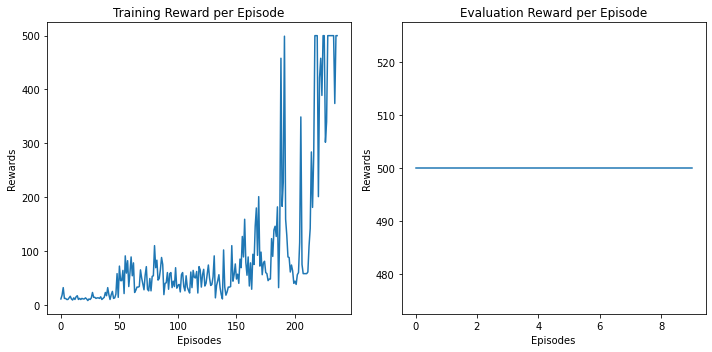

In [236]:
fig = plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
xn = range(len(eps_rewards1))
plt.plot(xn,eps_rewards1)
plt.title('Training Reward per Episode')
plt.ylabel('Rewards')
plt.xlabel('Episodes')


plt.subplot(1,2,2)
x1= range(len(cp1))
plt.plot(x1,cp1)
plt.title('Evaluation Reward per Episode')
plt.ylabel('Rewards')
plt.xlabel('Episodes')

fig.tight_layout()
plt.show()

**Lunar Lander**

In [250]:
env2 = gym.make("LunarLander-v2")
eps_rewards2=train(env2,0.001,0.995,1500,2,1)


In [262]:
actor1=torch.load("actor_model_lunarlander.pt")
cp2 = evaluate_model(env2,actor1, 10)


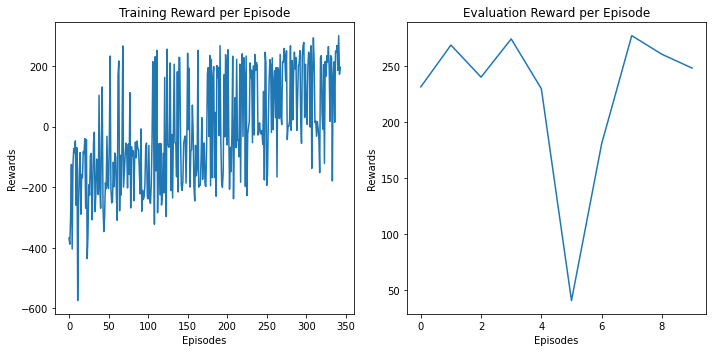

In [260]:
fig = plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
xn = range(len(eps_rewards2))
plt.plot(xn,eps_rewards2)
plt.title('Training Reward per Episode')
plt.ylabel('Rewards')
plt.xlabel('Episodes')


plt.subplot(1,2,2)
x1= range(len(cp2))
plt.plot(x1,cp2)
plt.title('Evaluation Reward per Episode')
plt.ylabel('Rewards')
plt.xlabel('Episodes')

fig.tight_layout()
plt.show()